In [1]:
import torch
from torchvision.transforms import v2
from torchvision.models import resnet34
from pathlib import Path
from utils import load_model

plantnet_model_path = Path("../models/plantnet_resnet34_best.tar")
plantnet_model = resnet34(num_classes=1081)
plantent_model = plantnet_model.to("cuda")

load_model(plantnet_model, filename=plantnet_model_path, use_gpu=True)

transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/home/kaka/repo/plants-toxic-for-cats/notebooks/utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(filename, map_location=device)


In [7]:
from PIL import Image
img = Image.open(r"../data/bing_subset_20/Aloe vera/Aloe vera_52.jpg")

img_tensor = transform(img).to("cuda")
img_tensor = img_tensor.unsqueeze(0)

plantnet_model.eval()

with torch.inference_mode():
    output = plantnet_model(img_tensor)
    print(output)
    
probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
top5_prob, top5_catid = torch.topk(probabilities, 5)

top5_prob, top5_catid


tensor([[-0.4195,  0.4138, -2.7225,  ..., -1.6042, -0.9202, -1.2782]],
       device='cuda:0')


(tensor([0.3758, 0.2243, 0.1758, 0.0415, 0.0326], device='cuda:0'),
 tensor([727, 152, 176, 213, 584], device='cuda:0'))

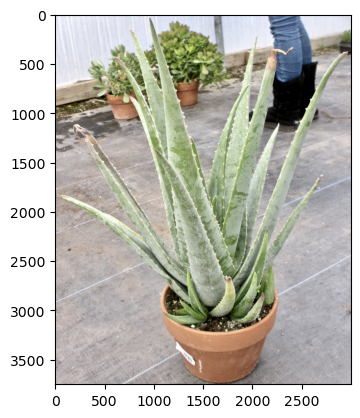

In [8]:
import matplotlib.pyplot as plt
import numpy as np

img = np.array(img)
plt.imshow(img)

In [25]:
from utils import load_model, get_model
import timm
from pathlib import Path
from torchinfo import summary
from torch import nn

plantnet_model_path = Path("/home/kaka/repo/plants-toxic-for-cats/models/vit_base_patch16_224_weights_best_acc.tar")
plantnet_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=1081)
load_model(plantnet_model, filename=plantnet_model_path, use_gpu=True)

for param in plantnet_model.parameters():
    param.requires_grad = False

num_features = plantnet_model.head.in_features
plantnet_model.head = nn.Linear(num_features, 47)
summary(plantnet_model)

Layer (type:depth-idx)                   Param #
VisionTransformer                        152,064
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       (590,592)
│    └─Identity: 2-2                     --
├─Dropout: 1-2                           --
├─Identity: 1-3                          --
├─Identity: 1-4                          --
├─Sequential: 1-5                        --
│    └─Block: 2-3                        --
│    │    └─LayerNorm: 3-1               (1,536)
│    │    └─Attention: 3-2               (2,362,368)
│    │    └─Identity: 3-3                --
│    │    └─Identity: 3-4                --
│    │    └─LayerNorm: 3-5               (1,536)
│    │    └─Mlp: 3-6                     (4,722,432)
│    │    └─Identity: 3-7                --
│    │    └─Identity: 3-8                --
│    └─Block: 2-4                        --
│    │    └─LayerNorm: 3-9               (1,536)
│    │    └─Attention: 3-10              (2,362,368)
│    │    └─Ident